In [1]:
import importlib.util
from typing import List


def load_py_grid(path: str, var_name: str = "GRID") -> List[List[int]]:
    """
    .py 파일 내부에 GRID = [...] 형태로 되어 있다고 가정하고 로드.
    """
    spec = importlib.util.spec_from_file_location("tmp_module", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return getattr(module, var_name)


def merge_grids(site_path: str, installable_path: str, constraint_path: str):
    # 1) load grids
    site = load_py_grid(site_path)              # 0 = 밖, 1 = 내부
    installable = load_py_grid(installable_path)  # 1 = 설치 가능 → 2로 변환
    constraint = load_py_grid(constraint_path)    # 1 = 설치 불가 → 3으로 변환

    ny = len(site)
    nx = len(site[0])

    merged = [[0]*nx for _ in range(ny)]

    for j in range(ny):
        for i in range(nx):
            v = site[j][i]

            # 기본: 현장 내부(1) 또는 외곽(0)
            if v == 1:
                merged[j][i] = 1
            else:
                merged[j][i] = 0

            # 설치 가능 영역 → 2
            if installable[j][i] == 1:
                merged[j][i] = 2

            # 제약(설치 불가능) → 3 (가장 강한 우선순위)
            if constraint[j][i] == 1:
                merged[j][i] = 3

    return merged


def save_to_py(grid, output_path: str, var_name: str = "GRID"):
    """grid를 Python 파일로 저장."""
    import pprint, os

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w", encoding="utf-8") as f:
        f.write("# Auto-generated merged grid\n")
        f.write(f"{var_name} = ")
        pprint.pprint(grid, stream=f, width=200)
    print(f"[+] Saved merged grid to {output_path}")


# ================================
# 사용 예시
# ================================
if __name__ == "__main__":
    merged = merge_grids(
        "./1.site.py",
        "./2.installable_grid.py",
        "./3.constraint_grid.py",
    )

    save_to_py(merged, "./4.final_grid.py")


[+] Saved merged grid to ./4.final_grid.py


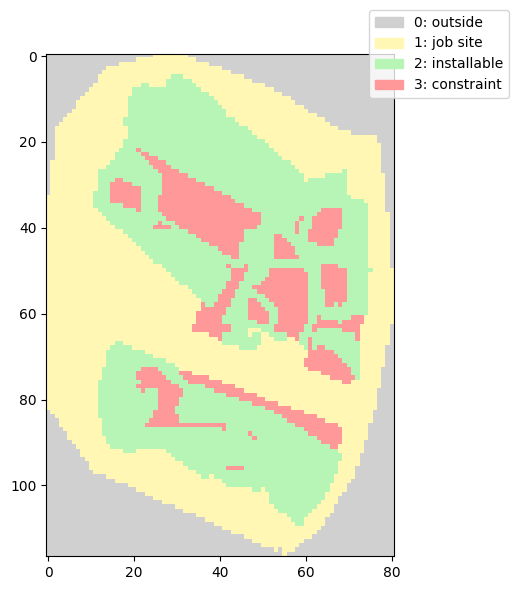

In [ ]:
import importlib.util
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

def load_py_grid(path: str, var_name: str = "GRID"):
    spec = importlib.util.spec_from_file_location("final_grid_module", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return getattr(module, var_name)

def visualize_grid(grid):
    arr = np.array(grid)

    cmap = ListedColormap([
        "#d0d0d0",  # 0 = 외곽
        "#fff7b3",  # 1 = 내부
        "#b6f5b6",  # 2 = 설치가능
        "#ff9999",  # 3 = 제약
    ])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(arr, cmap=cmap, norm=norm, origin="upper")

    legend_patches = [
        mpatches.Patch(color="#d0d0d0", label="0: outside"),
        mpatches.Patch(color="#fff7b3", label="1: job site"),
        mpatches.Patch(color="#b6f5b6", label="2: installable"),
        mpatches.Patch(color="#ff9999", label="3: restricted"),
    ]
    plt.legend(handles=legend_patches, loc="right", bbox_to_anchor=(1.35, 1.0))
    plt.tight_layout()
    plt.show()

# 4.final_grid.py 로드 + 시각화
grid = load_py_grid("4.final_grid.py", var_name="GRID")
visualize_grid(grid)
